# Hej Thomas
Jeg har tilføjet nogle forkalre kommetare fra linje 73 af
Bemærk jeg har haft noge kernel dør problemer

In [2]:
#%matplotlib
from classy import Class
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
import scipy.integrate as sc
import scipy.optimize as optimize
import scipy.interpolate

import matplotlib.pyplot as plt
import scipy.integrate as inv

import scipy.special as special
from time import time


In [3]:
print(np.pi)

3.141592653589793


TypeError: argument of type 'NoneType' is not iterable

Exception ignored in: 'classy.Class.__dealloc__'
Traceback (most recent call last):
  File "classy.pyx", line 208, in classy.Class.struct_cleanup
TypeError: argument of type 'NoneType' is not iterable


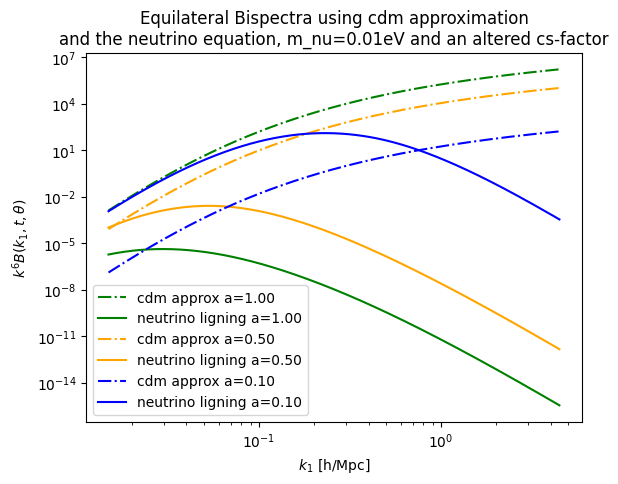

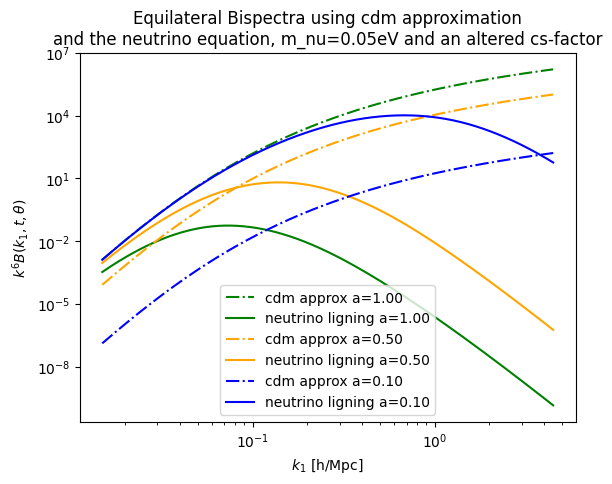

In [4]:
def TEST(kvec=[1],k_ind=0,z=800,mv_test=1 ,Omega_M = 0.99,
         Omega_b=0.01,PLOT_FIGUR=True,
         EdSitter=True,interpolation_type="cubic"):

    def Power(x,k):
        return np.power(x,k)
    def Cos(x):
        return np.cos(x)
    def Sin(x):
        return np.sin(x)
    def CosIntegral(x):
        return special.sici(x)[1]
    def SinIntegral(x):
        return special.sici(x)[0]
    def Sqrt(x):
        return np.sqrt(x)
    def Sinc(x):
        return np.sinc(x)
    
    Omega_lambda = 1 - Omega_M - Omega_b
    cs_factor = (25*special.zeta(5)/special.zeta(3))**0.5
    cs_factor /= 4
    factor = cs_factor
    k = kvec[k_ind]
    
    # CLASS stuff
    H0=67
    Tv_k = 1.947
    # in MeV
    h = 0.6704
    kb = 8.617e-11 # MeV/K
    T_0 = Tv_k * kb
    cosmo_dict ={'H0':H0, 'Omega_cdm':Omega_M,'Omega_b':Omega_b, 'k_output_values':str(kvec).strip('[]')
                 ,"N_ncdm":1,"m_ncdm":mv_test # massen er givet i eV s' jeg ganger min egen test m_v skal være en faktor  1e-6 mindre
               ,'output':'tCl, lCl, dTk, vTk, pCl', 'lensing':'yes',
                "ncdm_fluid_approximation":3
                , "YHe":0.25
                }

    c = 3*1e5 # speed of lign in km/s
    H0 /= c # i 1/Mpc

    cosmo = Class()
    cosmo.set(cosmo_dict)
    cosmo.compute()
    bg = cosmo.get_background()
    pts = cosmo.get_perturbations()['scalar']
    # Here we create/import the powerspectrum values from class
    tranf = cosmo.get_transfer(z=0)
    prim = cosmo.get_primordial()
    k = tranf['k (h/Mpc)'] * h
    
    tid = bg['proper time [Gyr]'] * c / 306.4
    d_m_af_k =  scipy.interpolate.interp1d(k,tranf["d_m"])
    prim_interp = scipy.interpolate.interp1d(prim["k [1/Mpc]"],prim["P_scalar(k)"], fill_value="extrapolate",kind="linear")
    p = lambda k: 2*np.pi**2 * d_m_af_k(k)** 2 *  prim_interp(k) * h**3  *k**(-3)    
    kvec = np.array(kvec)
    mv = mv_test * 1e-6

    def cs(a):
        Tv_k = 1.947 # kelvin # MeV
        kb = 8.617e-11 # MeV/K
        T_0 = Tv_k * kb
        mv = mv_test * 1e-6
        cs_factor = (25*special.zeta(5)/special.zeta(3))**0.5
        cs_factor /= 8
        return cs_factor *T_0 / a / mv
    
    def H(a):
        return H0 * np.sqrt(Omega_M /a + Omega_lambda * a**2)    
    
    
    # simuler-funktionen returnere powerspektret fro neutrinoer og CDM
    
    def simuler(z_slut=0): # z_slut er for at man kan kigge på powerspektret på forskellige tidspunkter.
        delta_approx = np.empty(len(kvec))
        neu_list     = np.empty(len(kvec)) 
        # denne forløkke gennere delta(k) for CDM og neutrinoerne
        for kind,k in enumerate(kvec): 
            delta_class = pts[kind]["delta_cdm"]
            theta_neutrino_class = pts[kind]["theta_ncdm[0]"]
            delta_neutrino_class = pts[kind]["delta_ncdm[0]"]        
            a_class = pts[kind]["a"]
            tau_class = pts[kind]["tau [Mpc]"]
            tid_class = scipy.interpolate.interp1d(bg['conf. time [Mpc]'],tid)(tau_class)
            interp_tid_from_a = scipy.interpolate.interp1d(a_class,tid_class,kind=interpolation_type,)
            delta_interp = scipy.interpolate.interp1d(tid_class,delta_class,kind=interpolation_type)        
            theta_neu_tid = scipy.interpolate.interp1d(tid_class,theta_neutrino_class)
            neu_tid = scipy.interpolate.interp1d(tid_class,delta_neutrino_class)        
            a0 = 1/(1+z)
            aslut = 1/(1+z_slut)
            # så a0 er a start men t0 er tid slut
            t0 = interp_tid_from_a(aslut) 
            #print("2. t0= %s"%t0)
            a_span = [a0,aslut]
            T0 = float(interp_tid_from_a(a0)) # a0**(3/2) * t0
            delta0 = delta_interp(T0)  
            tspan = [T0,t0]        
            def f2(t):
                C1 = np.sqrt(neu_tid(T0)**2 + (theta_neu_tid(T0)*a0/ (cs(a0)*k))**2)
                C2 = np.pi / 2 * ( 3 * cs(a0) * k * t0 * a0 )**2 * (delta0/a0)
                dcdm = delta0/a0        
                a = (t/t0)**(2/3)
                val = 3 * cs(a) * k * t0 * np.sqrt(a)        
                return dcdm*a+C1*Cos(val)+val**2*a*dcdm*Cos(val)*CosIntegral(val)-C2*Sin(val)+val**2*a*dcdm*Sin(val)*SinIntegral(val) 
            
            delta_approx[kind] = delta0/a0 * aslut
            neu_list[kind] = f2(t0)
        
        
        # Jeg har haft lidt bøvl med at få interpolations funktionerne til at virke. Med STOR hjælp fra Emil er det nu fikset
        # Det kræver at man interpolere log(x) og log(y)
        
        logkvec = np.log10(kvec)
        
        def p2(delta, k):
            return 2 * np.pi ** 2 * delta**2 *  prim_interp(k) * h**3 *  k**(-3)

        p_approx_interp = scipy.interpolate.interp1d(logkvec, np.log10(p2(delta_approx, kvec)), kind=interpolation_type)
        p_neu_lig_interp = scipy.interpolate.interp1d(logkvec, np.log10(p2(neu_list, kvec)), kind=interpolation_type)
        # powerspektre-funktionerne
        def p_approx(k):
            return 10** p_approx_interp(np.log10(k))    
        def p_neu_lig(k):
            return 10** p_neu_lig_interp(np.log10(k))

    
        return p_approx,p_neu_lig
     
    # Kernelen
    def K(k1,t,theta):
        k2 = k1 * t
        bn = 1
        an = 2/7
        res= (bn - an) + bn/2 *  np.cos(np.pi-theta) * (k2/k1 + k1/k2) + an * (np.cos(np.pi-theta))**2
        return res 
        
    # Bispektret, p variablen er der for at jeg ikke skal lave en bispektre funktion for hver type powerspketre jeg har.
    def Bispektrum(k1,t,theta,p):
        k2 = t * k1
        phi = np.pi - theta
        k3 = np.sqrt((k2*np.sin(phi))**2 + (k2*np.cos(phi)+k1)**2)    
        
        # Vi skal også bruge vinklerne mellem k2 og k3 og k3 og k2
        # vinklen mellem k2 og k3:
        theta2 = np.arccos((k3**2 + k2**2 - k1**2) / ( 2 * k3 * k2 )) 
        # vinklen mellem k3 og k1:
        theta3 = np.pi - theta2 - theta
        # vi skal også bruge de forskellige skaleringer 
        t2 = k3/k2
        t3 = k1/k3           
        res =  (2*p(k1)*p(k2)*K(k1,t,theta) +2*p(k3)*p(k1)*K(k3,t3,theta3) +2*p(k2)*p(k3)*K(k2,t2,theta2))
        return res        
    
    
    #plt.figure(1)
    plt.figure(np.random.randint(1,13241324123123))
    theta = np.linspace(0,np.pi/2,100)
    k1 = np.logspace(-2,np.log10(3),500) / h
    # med altered cs-faktorer henvises der til at der i lydhastighedsfunktionen står cs_factor /= 8, da der for neutrino-ligningen
    # til at passe bedre med class' neutrinoer. Det har dog ikke en reel effekt på bispektret så vidt jeg kan se.

    plt.title("Equilateral Bispectra using cdm approximation\nand the neutrino equation, m_nu=%seV and an altered cs-factor"%mv_test)
    
    # her generes og plottes Bispektret for cdm og neutrinoerne for a = 1 , a = 1/2 og a = 1/10
    z1 = 0
    p_approx, p_neu_lig= simuler(z1)
    plt.loglog(k1,k1**6*Bispektrum(k1,1,np.pi/3,p_approx),"-.",color="g",label="cdm approx a=%.2f"%(1/(1+z1)))
    plt.loglog(k1,k1**6*Bispektrum(k1,1,np.pi/3,p_neu_lig),color="g",label="neutrino ligning a=%.2f"%(1/(1+z1)))
    #plt.loglog(k1,k1**6*Bispektrum(k1,1,np.pi/3,p_neu_lig),label="neutrino ligning mv=%.2feV"%mv_test)
    
    
    z1 = 1
    p_approx, p_neu_lig= simuler(z1)
    plt.loglog(k1,k1**6*Bispektrum(k1,1,np.pi/3,p_approx),"-.",color="orange",label="cdm approx a=%.2f"%(1/(1+z1)))
    plt.loglog(k1,k1**6*Bispektrum(k1,1,np.pi/3,p_neu_lig),color="orange",label="neutrino ligning a=%.2f"%(1/(1+z1)))
    
    
    z1 = 9
    p_approx, p_neu_lig= simuler(z1)
    plt.loglog(k1,k1**6*Bispektrum(k1,1,np.pi/3,p_approx),"-.",color="b",label="cdm approx a=%.2f"%(1/(1+z1)))
    plt.loglog(k1,k1**6*Bispektrum(k1,1,np.pi/3,p_neu_lig),color="b",label="neutrino ligning a=%.2f"%(1/(1+z1)))
    
    
    plt.xlabel("$k_1$ [h/Mpc]")
    plt.ylabel("$k^6 B(k_1,t,\\theta)$")
    plt.legend()
    #plt.ylim(1e-20,1e7)
    plt.savefig("Equilateral Bispectra using cdm approximation with altered cs_factor and the neutrino equation, m_nu=%seV.png"%mv_test)
    #plt.savefig("Equilateral Bispectra sammenligning med Johans figur 4.11 m_nu=%seV.png"%mv_test)
    
    
kvec1 = list(np.logspace(-3,1,10)) 
TEST(kvec = kvec1,mv_test=0.01)
TEST(kvec = kvec1,mv_test=0.05)
#TEST(kvec = kvec1,mv_test=0.2)
#TEST(kvec = kvec1,mv_test=0.3)

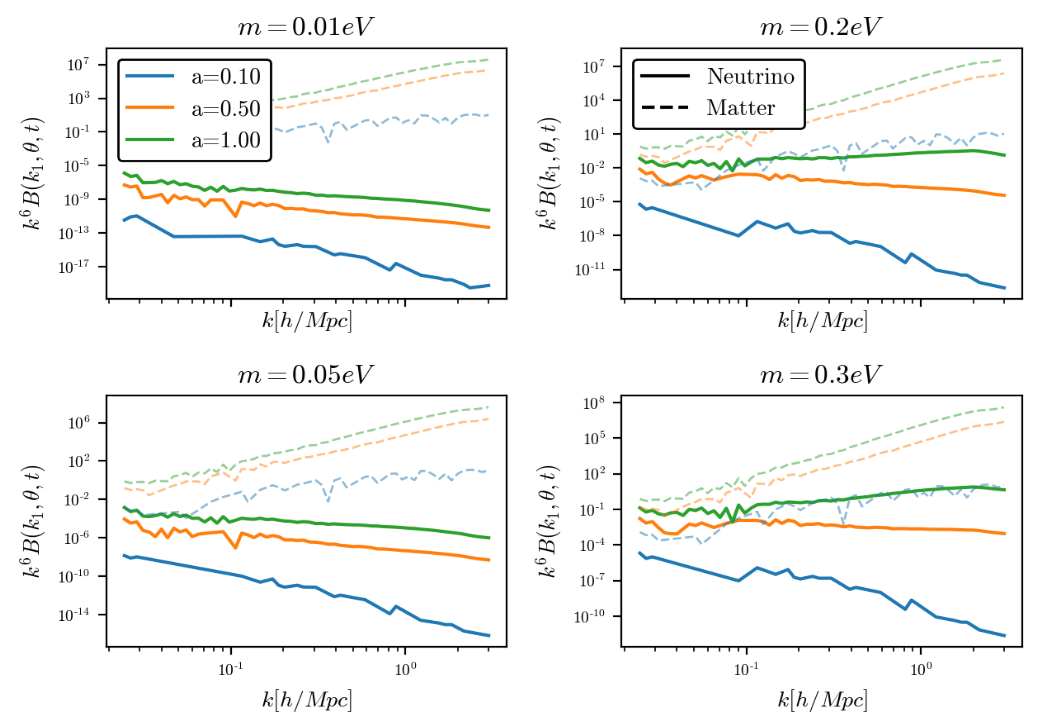